## Monte Carlo Tree Search (MCTS) algorithm implementation and testing

粗略地说，MCTS 允许我们依靠统计数据而不是全面探索来搜索最佳动作，因此允许我们以比暴力方法更少的限制来导航大型状态空间。

事实上，引导搜索是为了更频繁地探索有希望的节点，收集的统计数据越多，获得的结果就越可靠。

更准确地说，MCTS 分为 4 个不同的步骤：

- **Selection:** 我们需要一种聪明的方法来探索树节点，从而产生更有希望的结果，因此我们需要一种方法来为节点提供价值以选择要选择的节点。
- **Expansion:** 一旦到达叶节点（即游戏的某个状态），我们需要考虑该节点所有可能的有效动作（即采取有效动作后的后续游戏状态）来扩展树。
- **Simulation:** 我们需要能够从某个节点（即游戏状态）玩完全随机的游戏。如果单独考虑，这样的转出将产生随机结果，但是，我们从这样的节点进行转出的次数越多，该节点的平均值估计就越准确。
- **Backpropagation:** 推出后，需要将这些结果反向传播到树上，以便将这些信息存储在上层节点中，从而将信息从叶子传递到根节点。

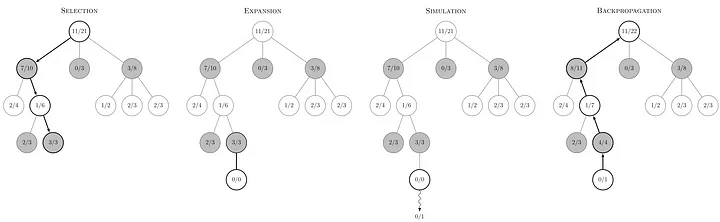

总而言之，我们越多地应用 MCTS 算法的 4 个步骤，我们从游戏的特定状态中收集到的关于下一个最佳行动的信息就越可靠和统计上有效。将其应用到每一步，我们就有了像老板一样玩游戏的策略！

### 1. MCTS implementation in OpenAI Gym Environments

In [4]:
'''
We will test our Monte Carlo Tree Search algorithm (MCTS) using an openAI gym environment named "CartPole".
You can read more information about the environment at this link:
https://www.gymlibrary.ml/environments/classic_control/cart_pole/

Feel free to change the environment with other as you like, changing the game name variable, 
but keep in mind that for this MCTS implementation both Actions and Observation must be Discrete. 
'''

# uncomment these lines below if you get a runtime error of gym package not found
# change the path value using your actual gym path using the 'pip show gym' command
#import sys
#path = "c:\\users\\my\\anaconda3\\envs\\mcts\\lib\\site-packages"
#sys.path.append(path)

import numpy
import gym

GAME_NAME = 'CartPole-v1'

env = gym.make(GAME_NAME)
    
GAME_ACTIONS = env.action_space.n
GAME_OBS = env.observation_space.shape[0]

print('In the ' + GAME_NAME + ' environment there are: ' + str(GAME_ACTIONS) + ' possible actions.')
print('In the ' + GAME_NAME + ' environment the observation is composed of: ' + str(GAME_OBS) + ' values.')

env.reset()
env.close()

In the CartPole-v1 environment there are: 2 possible actions.
In the CartPole-v1 environment the observation is composed of: 4 values.


### 接下来对树上的每个节点进行定义，以便进行后面的搜索步骤，即：selection、expansion、simulation、backpropagation。

1）首先对每个节点的基础属性进行定义：
- child：当前节点下的子节点。
- T：表示从此节点开始的 rollout 值的总和。
- N：对当前节点搜索/访问的次数。
- game：是节点所代表的当前状态的游戏环境。它是我们当前正在玩的原始游戏的副本，以便我们可以用它来模拟搜索。它表示游戏的当前状态，这将导致将所有操作从根节点应用到节点本身。注意这里面的游戏环境最好是简单的、较小的搜索空间，如果复杂度过高，搜索所用的时间与占用的空间会急剧增加；类似围棋这样复杂的游戏，为了避免MCTS算法在状态空间非常大的游戏中使用时出现不足，AlphaGo与AlphaZero则使用神经网络来近似树节点的Value和Policy，从而使极限MCTS算法的缺点被克服了。
- observation：是该节点中游戏的当前状态，在我们的示例中，它将是如上所述的 4 个值。
- done：会告诉我们此时游戏是否结束，从而停止搜索。
- parent：与父节点的连接，用于反向传播。
- action_index：是导致该节点的操作的索引（即该节点的父节点为进入该节点而采取的操作）。


```python
class Node:
    
    '''
    The Node class represents a node of the MCTS tree. 
    It contains the information needed for the algorithm to run its search.
    '''

    def __init__(self, game, done, parent, observation, action_index):
          
        # child nodes
        self.child = None
        
        # total rewards from MCTS exploration
        self.T = 0
        
        # visit count
        self.N = 0        
                
        # the environment
        self.game = game
        
        # observation of the environment
        self.observation = observation
        
        # if game is won/loss/draw
        self.done = done

        # link to parent node
        self.parent = parent
        
        # action index that leads to this node
        self.action_index = action_index
```

2）getUCBscore方法：

该公式称为 UCB（置信上限），用以平衡在搜索过程中的exploitation (i.e. pick the best known action) 和exploration(i.e. explore new actions)：
$$
UCB_{Score} = \left( \frac{T}{N} \right) + c \sqrt{\frac{\log(N_{TopNode})}{N}}
$$
- **exploitation项**为节点的当前估计值 $\left( \frac{T}{N} \right)$，即从当前节点开始的rollout值总和/访问次数。
- **exploration项**与节点被访问次数成反比，相对于其父节点的访问次数：$\sqrt{\frac{\log(N_{TopNode})}{N}}$
- 还有一个可调节常数**c**可以为**exploration项**提供或多或少的参考比重。


```python
def getUCBscore(self):
        
    '''
    This is the formula that gives a value to the node.
    The MCTS will pick the nodes with the highest value.        
    '''
    
    # Unexplored nodes have maximum values so we favour exploration
    if self.N == 0:
        return float('inf')
    
    # We need the parent node of the current node 
    top_node = self
    if top_node.parent:
        top_node = top_node.parent
        
    # We use one of the possible MCTS formula for calculating the node value
    return (self.T / self.N) + c * sqrt(log(top_node.N) / self.N)
```

3）接下来我们需要一个函数来创建当前节点的子节点：

请注意我们如何始终使用可用的整个游戏操作 ( GAME_ACTIONS ) 并为每个操作创建一个子操作，将其关联到我们应用此类操作 ( game.step(action) ) 的游戏环境的副本，并存储信息子节点中游戏的结果状态。
```python
def create_child(self):
        
    '''
    We create one children for each possible action of the game, 
    then we apply such action to a copy of the current node enviroment 
    and create such child node with proper information returned from the action executed
    '''
    
    if self.done:
        return

    actions = []
    games = []
    for i in range(GAME_ACTIONS): 
        actions.append(i)           
        new_game = deepcopy(self.game)
        games.append(new_game)
        
    child = {} 
    for action, game in zip(actions, games):
        observation, reward, done, _ = game.step(action)
        child[action] = Node(game, done, self, observation, action)                        
        
    self.child = child
```


4）我们现在已经准备好进行算法的核心，即搜索（exploration）发生的地方：
沿着树的搜索从某个节点（Node）开始，并递归地选择一个使前面定义的UCB Score最大化的子节点。这将指导我们的搜索，直到到达叶节点。

此时，如果这是我们第一次访问该叶节点，我们将播放 rollout 并存储统计信息。

如果不是第一次访问该节点，那么我们将创建它的子节点，并从一个随机选择的子节点开始进行 rollout。

在每种情况下，更新的统计数据、值和访问计数都会反向传播到父节点，直至根节点（root Node）。

```python
def explore(self):
        
    # find a leaf node by choosing nodes with max U.
    
    current = self
    
    while current.child:

        child = current.child
        max_U = max(c.getUCBscore() for c in child.values())
        actions = [ a for a, c in child.items() if c.getUCBscore() == max_U ]
        if len(actions) == 0:
            print("error zero length ", max_U)                      
        action = random.choice(actions)
        current = child[action]
        
    # play a random game, or expand if needed          
    # 如果是第一次访问
    if current.N < 1:
        current.T = current.T + current.rollout()
    # 如果不是第一次访问
    else:
        current.create_child()
        if current.child:
            current = random.choice(current.child)
        current.T = current.T + current.rollout()
        
    current.N += 1      
            
    # update statistics and backpropagate
        
    parent = current
        
    while parent.parent:
        
        parent = parent.parent
        parent.N += 1
        parent.T = parent.T + current.T  
```

5）rollout，我们只需要定义如何使用当前节点的游戏副本（即在实际游戏状态下）进行随机推出：

Rollout 是从当前节点的环境副本开始，使用随机移动进行的随机游戏。

这将为我们提供当前节点的一个值。

**单独来看，这个值是非常随机的，但是，我们对这样的节点进行的rollout越多，该节点值的平均值就会越准确。这是蒙特卡洛树搜索（MCTS）算法的核心。**

```python
def rollout(self):
        
    if self.done:
        return 0        
    
    v = 0
    done = False
    new_game = deepcopy(self.game)
    while not done:
        action = new_game.action_space.sample()
        observation, reward, done, _ = new_game.step(action)
        v = v + reward
        if done:
            new_game.reset()
            new_game.close()
            break             
    return v
```

6）我们需要定义 **搜索完成后** 如何选择 **下一步（next step）** 操作：

一旦我们在树中进行了足够的搜索，其中包含的值应该是统计上准确的。

在某个时候，我们会要求从当前节点进行下一个动作，这个函数就是做这个的。

选择这样一个动作可能有不同的方法，在这种实现中，策略如下：

***随机选择访问次数最多的节点中的一个，因为这意味着它无论如何都会有一个好的值。***

```python
def next(self):

    if self.done:
        raise ValueError("game has ended")

    if not self.child:
        raise ValueError('no children found and game hasn\'t ended')
    
    child = self.child
    
    max_N = max(node.N for node in child.values())
   
    max_children = [ c for a,c in child.items() if c.N == max_N ]
    
    if len(max_children) == 0:
        print("error zero length ", max_N) 
        
    max_child = random.choice(max_children)
    
    return max_child, max_child.action_index
```

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy
from math import *
import random

c = 1.0

class Node:
    
    '''
    The Node class represents a node of the MCTS tree. 
    It contains the information needed for the algorithm to run its search.
    '''

    def __init__(self, game, done, parent, observation, action_index):
          
        # child nodes
        self.child = None
        
        # total rewards from MCTS exploration
        self.T = 0
        
        # visit count
        self.N = 0        
                
        # the environment
        self.game = game
        
        # observation of the environment
        self.observation = observation
        
        # if game is won/loss/draw
        # 修改 done 的判断逻辑
        if isinstance(done, tuple):
            # 如果 done 是元组 (terminated, truncated)
            self.done = done[0] or done[1]
        else:
            # 如果 done 是布尔值
            self.done = done

        # link to parent node
        self.parent = parent
        
        # action index that leads to this node
        self.action_index = action_index
        
        
    def getUCBscore(self):
        
        '''
        This is the formula that gives a value to the node.
        The MCTS will pick the nodes with the highest value.        
        '''
        
        # Unexplored nodes have maximum values so we favour exploration
        if self.N == 0:
            return float('inf')
        
        # We need the parent node of the current node 
        top_node = self
        if top_node.parent:
            top_node = top_node.parent
            
        # We use one of the possible MCTS formula for calculating the node value
        return (self.T / self.N) + c * sqrt(log(top_node.N) / self.N)
    
    
    def detach_parent(self):
        # free memory detaching nodes
        del self.parent
        self.parent = None
       
        
    def create_child(self):
        
        '''
        We create one children for each possible action of the game, 
        then we apply such action to a copy of the current node enviroment 
        and create such child node with proper information returned from the action executed
        '''
        
        if self.done:
            return
    
        actions = []
        games = []
        for i in range(GAME_ACTIONS): 
            actions.append(i)           
            new_game = deepcopy(self.game)
            games.append(new_game)
            
        child = {} 
        for action, game in zip(actions, games):
            # 适应新版本 Gym API
            step_result = game.step(action)
            if len(step_result) == 4:
                observation, reward, done, _ = step_result
            else:
                observation, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
                
            child[action] = Node(game, done, self, observation, action)                        
            
        self.child = child
                
            
    def explore(self):
        
        '''
        The search along the tree is as follows:
        - from the current node, recursively pick the children which maximizes the value according to the MCTS formula
        - when a leaf is reached:
            - if it has never been explored before, do a rollout and update its current value
            - otherwise, expand the node creating its children, pick one child at random, do a rollout and update its value
        - backpropagate the updated statistics up the tree until the root: update both value and visit counts
        '''
        
        # find a leaf node by choosing nodes with max U.
        
        current = self
        
        while current.child:

            child = current.child
            max_U = max(c.getUCBscore() for c in child.values())
            actions = [ a for a,c in child.items() if c.getUCBscore() == max_U ]
            if len(actions) == 0:
                print("error zero length ", max_U)                      
            action = random.choice(actions)
            current = child[action]
            
        # play a random game, or expand if needed          
            
        if current.N < 1:
            current.T = current.T + current.rollout()
        else:
            current.create_child()
            if current.child:
                current = random.choice(current.child)
            current.T = current.T + current.rollout()
            
        current.N += 1      
                
        # update statistics and backpropagate
            
        parent = current
            
        while parent.parent:
            
            parent = parent.parent
            parent.N += 1
            parent.T = parent.T + current.T           
            
            
    def rollout(self):
        
        '''
        The rollout is a random play from a copy of the environment of the current node using random moves.
        This will give us a value for the current node.
        Taken alone, this value is quite random, but, the more rollouts we will do for such node,
        the more accurate the average of the value for such node will be. This is at the core of the MCTS algorithm.
        '''
        
        if self.done:
            return 0        
        
        v = 0
        done = False
        terminated = False  # 新增
        new_game = deepcopy(self.game)
        while not (done or terminated):  # 修改条件
            action = new_game.action_space.sample()
            # 适应新版本 Gym API
            step_result = new_game.step(action)
            if len(step_result) == 4:
                observation, reward, done, _ = step_result
            else:
                observation, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
                
            v = v + reward
            if done or terminated:
                new_game.reset()
                new_game.close()
                break             
        return v

    
    def next(self):
        
        ''' 
        Once we have done enough search in the tree, the values contained in it should be statistically accurate.
        We will at some point then ask for the next action to play from the current node, and this is what this function does.
        There may be different ways on how to choose such action, in this implementation the strategy is as follows:
        - pick at random one of the node which has the maximum visit count, as this means that it will have a good value anyway.
        '''

        if self.done:
            raise ValueError("game has ended")

        if not self.child:
            raise ValueError('no children found and game hasn\'t ended')
        
        child = self.child
        
        max_N = max(node.N for node in child.values())
       
        max_children = [ c for a,c in child.items() if c.N == max_N ]
        
        if len(max_children) == 0:
            print("error zero length ", max_N) 
            
        max_child = random.choice(max_children)
        
        return max_child, max_child.action_index

现在一切都准备好了，我们需要定义用于玩游戏的策略（Policy）：

我们使用蒙特卡洛树搜索（MCTS）的策略非常简单：
- 为了从当前节点选择最佳动作：
  - 从该节点开始探索树，进行一定次数的迭代以收集可靠的统计数据
  - 选择根据MCTS来说最佳的下一个可能动作的节点


In [22]:
from copy import deepcopy
import random

MCTS_POLICY_EXPLORE = 100 # MCTS exploring constant: the higher, the more reliable, but slower in execution time

def Policy_Player_MCTS(mytree):  

    '''
    Our strategy for using the MCTS is quite simple:
    - in order to pick the best move from the current node:
        - explore the tree starting from that node for a certain number of iterations to collect reliable statistics
        - pick the node that, according to MCTS, is the best possible next action
    '''
    
    for i in range(MCTS_POLICY_EXPLORE):
        mytree.explore()
        
    next_tree, next_action = mytree.next()
        
    # note that here we are detaching the current node and returning the sub-tree 
    # that starts from the node rooted at the choosen action.
    # The next search, hence, will not start from scratch but will already have collected information and statistics
    # about the nodes, so we can reuse such statistics to make the search even more reliable!
    next_tree.detach_parent()
    
    return next_tree, next_action

该策略很简单：

每次我们需要在游戏中执行某个动作时，我们都会使用 MCTS 来探索并选择刚刚讨论的最佳可能的下一步动作。搜索根据固定参数 ( MCTS_POLICY_EXPLORE ) 的值进行一定次数的迭代，并且正如所讨论的，**我们在搜索中收集统计数据所花费的时间越多，结果就越可靠**。

我们将把这样的政策应用到游戏的每一个动作中，以培养MCTS指导的专家玩家。


episode #1
reward_e 500.0
episode #2
reward_e 500.0
episode #3
reward_e 500.0
episode #4
reward_e 500.0
episode #5
reward_e 500.0
episode #6
reward_e 500.0
episode #7
reward_e 500.0
episode #8
reward_e 500.0
episode #9
reward_e 500.0
episode #10
reward_e 500.0


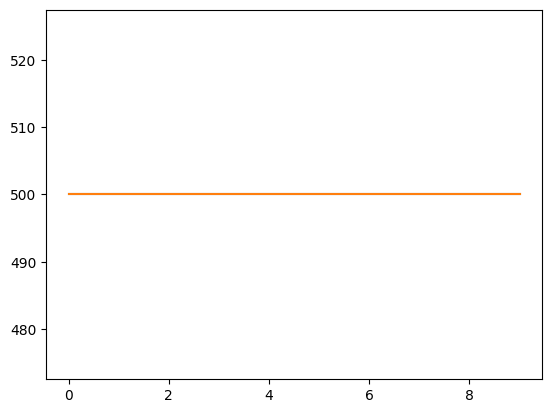

moving average: 500.0


In [23]:
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output

episodes = 10
rewards = []
moving_average = []

'''
Here we are experimenting with our implementation:
- we play a certain number of episodes of the game
- for deciding each move to play at each step, we will apply our MCTS algorithm
- we will collect and plot the rewards to check if the MCTS is actually working.
- For CartPole-v0, in particular, 200 is the maximum possible reward. 
'''

for e in range(episodes):
    reward_e = 0    
    game = gym.make(GAME_NAME)
    observation = game.reset() 
    done = False
    terminated = False
    truncated = False
    
    new_game = deepcopy(game)
    mytree = Node(new_game, False, 0, observation, 0)
    
    print('episode #' + str(e+1))
    
    while not (done or terminated or truncated):
        try:
            mytree, action = Policy_Player_MCTS(mytree)
            # observation, reward, terminated, truncated, info
            step_result = game.step(action)
            if len(step_result) == 4:
                observation, reward, done, _ = step_result
            else:
                observation, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            reward_e = reward_e + reward
            
            #game.render() # uncomment this if you want to see your agent in action!
                    
        except ValueError as e:
            # 处理游戏结束的情况
            print(f"Episode ended: {e}")
            break
            
    print('reward_e ' + str(reward_e))
    game.close()
    
    rewards.append(reward_e)
    moving_average.append(np.mean(rewards[-100:]))
    
plt.plot(rewards)
plt.plot(moving_average)
plt.show()
print('moving average: ' + str(np.mean(rewards[-20:])))

作为示例的CartPole-v1环境非常简单，MCTS 算法能够在合理的时间内收集足够的统计数据，使其成为每场比赛不断达到 500 分的好玩家（这是环境允许的最大值） ！

但可以注意到，即使是这样一个简单任务中，MCTS的每次搜索，也耗费了大量的时间来计算，与强化学习相结合的策略，将在下一节AlphaZero中来实现。

### 2. MCTS implementation on tic tac toe(井字棋游戏)

1）首先创建井字棋游戏环境

In [24]:
import numpy as np
import random
from math import *
import copy
import pickle
import time


class GameState:
    def __init__(self):
        self.board = [' '] * 9
        self.current_player = 'X'

    def get_legal_actions(self):
        return [i for i in range(9) if self.board[i] == ' ']

    def take_action(self, action):
        new_state = copy.deepcopy(self)
        new_state.board[action] = self.current_player
        new_state.current_player = 'O' if self.current_player == 'X' else 'X'
        return new_state

    def is_terminal(self):
        return self.get_winner() is not None or ' ' not in self.board

    def get_winner(self):
        winning_combinations = [
            (0, 1, 2), (3, 4, 5), (6, 7, 8),  # Rows
            (0, 3, 6), (1, 4, 7), (2, 5, 8),  # Columns
            (0, 4, 8), (2, 4, 6)  # Diagonals
        ]
        for combo in winning_combinations:
            if self.board[combo[0]] == self.board[combo[1]] == self.board[combo[2]] != ' ':
                return self.board[combo[0]]
        return None

    def print_board(self):
        for i in range(0, 9, 3):
            print(f"{self.board[i]} | {self.board[i + 1]} | {self.board[i + 2]}")
            if i < 6:
                print("---------")

    def heuristic_value(self):
        winner = self.get_winner()
        if winner == 'X':
            return 1
        elif winner == 'O':
            return -1
        return 0

2）定义书搜索节点（Node）
这是类的构造函数，用于初始化一个节点。

- state：节点对应的状态。
- parent：父节点，用于追踪节点的祖先。
- action：从父节点到当前节点所采取的动作。
- children：存储子节点的字典，键是动作，值是对应的子节点。
- visits：记录节点被访问的次数。
- value：记录节点的值，通常用于评估。
- untried_actions：存储当前状态所有合法但尚未尝试的动作。

expand方法：
扩展节点的方法，用于MCTS中的扩展阶段。

- 从 untried_actions 中取出一个未尝试的动作。
- 通过在当前状态上执行这个动作来获得下一个状态。
- 创建一个新的子节点，并将其添加到 children 字典中。
- 返回新创建的子节点。

select_child：选择子节点的方法，用于MCTS中的选择阶段。

- c_param：探索-利用参数，用于平衡探索（exploration）和利用（exploitation）。
- 方法返回具有最高价值的子节点，这个价值是通过节点的值除以其访问次数（加上一个小的常数以避免除以零）再加上一个与节点访问次数成反比的探索项来计算的。
$$
UCB_{Score}=\frac{\text{child.value}}{\text{child.visits} + 1e-8} + c_{\text{param}} \times \sqrt{\frac{2 \times \log(\text{self.visits} + 1)}{\text{child.visits} + 1e-8}}
$$

(注意：这里在CartPole-v1中选用的是$UCB_{Score} = \left( \frac{T}{N} \right) + c \sqrt{\frac{\log(N_{TopNode})}{N}}$，计算UCB Score，而在这里用的是child.value原因是上面的CartPole-v1环境在运算时是先select child而后再计算UCB Score，详见代码：
```python
while current.child:

    child = current.child
    max_U = max(c.getUCBscore() for c in child.values())
    actions = [ a for a, c in child.items() if c.getUCBscore() == max_U ]
    if len(actions) == 0:
        print("error zero length ", max_U)                      
    action = random.choice(actions)
    current = child[action]
)
```


In [25]:
class Node:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.value = 0
        self.untried_actions = state.get_legal_actions()

    def select_child(self, c_param):
        return max(self.children.values(),
                   key=lambda child: child.value / (child.visits + 1e-8) +
                                     c_param * sqrt(2 * log(self.visits + 1) / (child.visits + 1e-8)))

    def expand(self):
        action = self.untried_actions.pop()
        next_state = self.state.take_action(action)
        child_node = Node(next_state, parent=self, action=action)
        self.children[action] = child_node
        return child_node

    def is_fully_expanded(self):
        return len(self.untried_actions) == 0

接下来实现MCTS整个算法：
这个 `MCTS` 类实现了蒙特卡洛树搜索（Monte Carlo Tree Search）算法，用于决策过程中的搜索和优化。以下是对类中每个方法的介绍：

1. `__init__(self, state, config)`：
   构造函数，初始化MCTS对象。
   - `state`：初始状态，可以是游戏的棋盘状态或其他任何需要进行搜索的状态。
   - `config`：配置字典，包含算法运行时需要的参数，如探索-利用参数 `c_param`、`epsilon`（用于epsilon-greedy策略）和 `max_depth`（模拟的最大深度）。

2. `search(self, time_limit)`：
   执行MCTS搜索的主函数。
   - `time_limit`：搜索的时间限制。
   - 该方法会持续进行选择（Selection）、扩展（Expansion）、模拟（Simulation）和反向传播（Backpropagation）步骤，直到时间耗尽。

3. `select_action(self, state, actions)`：
   选择动作的函数，实现epsilon-greedy策略。
   - `state`：当前状态。
   - `actions`：当前状态下所有合法的动作。
   - 以一定概率 `epsilon` 随机选择动作，以探索；否则选择当前评估值最高的动作，以利用。

4. `action_value(self, state, action)`：
   评估一个动作的价值。
   - `state`：当前状态。
   - `action`：要评估的动作。
   - 通过执行动作并获取下一个状态的启发式价值来评估动作的价值。

5. `get_best_action(self)`：
   获取最佳动作。
   - 如果根节点没有子节点，则随机选择一个合法动作。
   - 否则，选择访问次数最多的子节点对应的动作，这通常意味着该动作是目前为止最好的动作。

6. `save_model(self, filename)`：
   保存MCTS模型到文件。
   - `filename`：要保存的文件名。
   - 使用 `pickle` 序列化根节点并保存到文件。

7. `load_model(cls, filename, config)`：
   从文件加载MCTS模型。
   - `filename`：要加载的文件名。
   - `config`：配置字典。
   - 使用 `pickle` 反序列化根节点，并重新创建MCTS对象。

In [26]:
class MCTS:
    def __init__(self, state, config):
        self.root = Node(state)
        self.config = config

    def search(self, time_limit):
        end_time = time.time() + time_limit
        while time.time() < end_time:
            node = self.root
            state = copy.deepcopy(node.state)

            # Selection
            while node.is_fully_expanded() and not state.is_terminal():
                node = node.select_child(self.config['c_param'])
                state = state.take_action(node.action)

            # Expansion
            if not state.is_terminal() and not node.is_fully_expanded():
                node = node.expand()
                state = state.take_action(node.action)

            # Simulation
            depth = 0
            while not state.is_terminal() and depth < self.config['max_depth']:
                actions = state.get_legal_actions()
                action = self.select_action(state, actions)
                state = state.take_action(action)
                depth += 1

            # Backpropagation
            value = state.heuristic_value()
            while node is not None:
                node.visits += 1
                node.value += value
                node = node.parent

    def select_action(self, state, actions):
        if random.random() < self.config['epsilon']:
            return random.choice(actions)
        else:
            return max(actions, key=lambda a: self.action_value(state, a))

    def action_value(self, state, action):
        next_state = state.take_action(action)
        return next_state.heuristic_value()

    def get_best_action(self):
        if len(self.root.children) == 0:
            return random.choice(self.root.state.get_legal_actions())

        return max(self.root.children.items(),
                   key=lambda item: item[1].visits)[0]

    def save_model(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.root, f)

    @classmethod
    def load_model(cls, filename, config):
        with open(filename, 'rb') as f:
            root = pickle.load(f)
        mcts = cls(root.state, config)
        mcts.root = root
        return mcts

In [27]:
def play_game(config):
    state = GameState()
    mcts = MCTS(state, config)

    while not state.is_terminal():
        state.print_board()
        print(f"\nCurrent player: {state.current_player}")

        if state.current_player == 'X':  # AI's turn
            mcts.search(config['time_limit'])
            action = mcts.get_best_action()
            print(f"AI chooses position: {action}")
        else:  # Human's turn
            while True:
                try:
                    action = int(input("Enter your move (0-8): "))
                    if action in state.get_legal_actions():
                        break
                    print("Invalid move, try again.")
                except ValueError:
                    print("Please enter a number between 0-8.")

        state = state.take_action(action)
        mcts = MCTS(state, config)

    state.print_board()
    winner = state.get_winner()
    if winner:
        print(f"\nPlayer {winner} wins!")
    else:
        print("\nIt's a draw!")

    mcts.save_model('mcts_model.pkl')

In [28]:
def main():
    print("Welcome to Tic-Tac-Toe!")
    print("Board positions are numbered from 0 to 8, left to right, top to bottom.")
    print("You will play as O, and the AI will play as X.")

    config = {
        'c_param': 1.4,
        'max_depth': 9,
        'epsilon': 0.1,
        'time_limit': 2  # seconds
    }

    while True:
        play_game(config)
        play_again = input("\nPlay again? (y/n): ")
        if play_again.lower() != 'y':
            break

In [29]:
main()

Welcome to Tic-Tac-Toe!
Board positions are numbered from 0 to 8, left to right, top to bottom.
You will play as O, and the AI will play as X.
  |   |  
---------
  |   |  
---------
  |   |  

Current player: X
AI chooses position: 4
  |   |  
---------
  | X |  
---------
  |   |  

Current player: O


Enter your move (0-8):  0


O |   |  
---------
  | X |  
---------
  |   |  

Current player: X
AI chooses position: 2
O |   | X
---------
  | X |  
---------
  |   |  

Current player: O


Enter your move (0-8):  6


O |   | X
---------
  | X |  
---------
O |   |  

Current player: X
AI chooses position: 5
O |   | X
---------
  | X | X
---------
O |   |  

Current player: O


Enter your move (0-8):  8


O |   | X
---------
  | X | X
---------
O |   | O

Current player: X
AI chooses position: 3
O |   | X
---------
X | X | X
---------
O |   | O

Player X wins!



Play again? (y/n):  n


如果要加载之前保存的模型，可以使用：
```python
mcts = MCTS.load_model('mcts_model.pkl')
```

### 3. MCTS implementation on Gobang（五子棋）

五子棋环境代码：

In [31]:
import numpy as np
import random
from math import *
import copy
import pickle

class GameState:
    def __init__(self):
        self.board_size = 15
        self.board = [[' ' for _ in range(self.board_size)] for _ in range(self.board_size)]
        self.current_player = 'X'   # X为黑子，O为白子
        self.last_move = None  # 记录最后一步的位置

    def get_legal_actions(self):
        """返回所有合法的落子位置"""
        actions = []
        # 优化：只考虑已有棋子周围的空位
        if self.last_move is None:  # 如果是第一步
            # 返回棋盘中心点及其周围位置
            center = self.board_size // 2
            for i in range(center-2, center+3):
                for j in range(center-2, center+3):
                    actions.append((i, j))
            return actions

        # 获取所有已下棋子的周围空位
        checked = set()
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board[i][j] != ' ':
                    # 检查周围3格范围内的空位
                    for di in range(-3, 4):
                        for dj in range(-3, 4):
                            ni, nj = i + di, j + dj
                            if (ni, nj) not in checked and \
                               0 <= ni < self.board_size and \
                               0 <= nj < self.board_size and \
                               self.board[ni][nj] == ' ':
                                actions.append((ni, nj))
                                checked.add((ni, nj))
        return actions if actions else [(self.board_size//2, self.board_size//2)]

    def take_action(self, action):
        """执行一步落子"""
        new_state = copy.deepcopy(self)
        i, j = action
        new_state.board[i][j] = self.current_player
        new_state.current_player = 'O' if self.current_player == 'X' else 'X'
        new_state.last_move = action
        return new_state

    def is_terminal(self):
        """判断游戏是否结束"""
        return self.get_winner() is not None or self.is_full()

    def is_full(self):
        """判断棋盘是否已满"""
        return all(self.board[i][j] != ' ' 
                  for i in range(self.board_size) 
                  for j in range(self.board_size))

    def get_winner(self):
        """检查是否有获胜者"""
        if self.last_move is None:
            return None
            
        i, j = self.last_move
        player = 'O' if self.current_player == 'X' else 'X'  # 上一个玩家

        # 检查八个方向
        directions = [(1,0), (0,1), (1,1), (1,-1)]
        for di, dj in directions:
            count = 1
            # 正向检查
            ni, nj = i + di, j + dj
            while 0 <= ni < self.board_size and 0 <= nj < self.board_size and \
                  self.board[ni][nj] == player:
                count += 1
                ni, nj = ni + di, nj + dj
            
            # 反向检查
            ni, nj = i - di, j - dj
            while 0 <= ni < self.board_size and 0 <= nj < self.board_size and \
                  self.board[ni][nj] == player:
                count += 1
                ni, nj = ni - di, nj - dj
                
            if count >= 5:
                return player
        return None

    def print_board(self):
        """打印棋盘"""
        print('   ' + ' '.join([f'{i:2}' for i in range(self.board_size)]))
        for i in range(self.board_size):
            print(f'{i:2} |', end=' ')
            for j in range(self.board_size):
                print(f'{self.board[i][j]} |', end=' ')
            print()
            print('   ' + '-' * (self.board_size * 4 + 1))

树节点的定义：

In [33]:
class Node:
    def __init__(self, state, parent=None, action=None):
        self.state = state
        self.parent = parent
        self.action = action
        self.children = {}
        self.visits = 0
        self.value = 0
        self.untried_actions = state.get_legal_actions()
        self.depth = 0 if parent is None else parent.depth + 1

    def select_child(self, config):
        """使用配置的参数选择子节点"""
        c_param = config['c_param']
        return max(self.children.values(),
                  key=lambda child: child.value/child.visits + 
                  c_param * sqrt(2*log(self.visits)/child.visits))

    def expand(self):
        """扩展一个新的子节点"""
        action = self.untried_actions.pop()
        next_state = self.state.take_action(action)
        child_node = Node(next_state, parent=self, action=action)
        self.children[action] = child_node
        return child_node

    def is_fully_expanded(self):
        return len(self.untried_actions) == 0

MCTS定义：

In [38]:
class MCTS:
    def __init__(self, state, config):
        self.root = Node(state)
        self.config = config

    def search(self):
        """基于时间限制的MCTS搜索"""
        start_time = time.time()
        n_simulations = 0

        while time.time() - start_time < self.config['time_limit']:
            node = self.root
            
            # Selection
            while node.is_fully_expanded() and not node.state.is_terminal():
                if node.depth >= self.config['max_depth']:
                    break
                node = node.select_child(self.config)

            # Expansion
            if not node.state.is_terminal() and not node.is_fully_expanded() and \
               node.depth < self.config['max_depth']:
                node = node.expand()

            # Simulation
            state = copy.deepcopy(node.state)
            current_depth = node.depth
            
            while not state.is_terminal() and current_depth < self.config['max_depth']:
                actions = state.get_legal_actions()
                # Epsilon-greedy strategy
                if random.random() < self.config['epsilon']:
                    action = random.choice(actions)
                else:
                    # 使用简单的启发式方法选择动作
                    action = self.get_heuristic_action(state, actions)
                state = state.take_action(action)
                current_depth += 1

            # Backpropagation
            winner = state.get_winner()
            while node is not None:
                node.visits += 1
                if winner is None:
                    node.value += 0.5
                elif winner == node.state.current_player:
                    node.value += 1
                node = node.parent

            n_simulations += 1

        print(f"完成 {n_simulations} 次模拟")
        return n_simulations

    def get_heuristic_action(self, state, actions):
        """简单的启发式方法来选择动作"""
        best_action = None
        best_score = float('-inf')
        
        for action in actions:
            score = self.evaluate_action(state, action)
            if score > best_score:
                best_score = score
                best_action = action
                
        return best_action or random.choice(actions)

    def evaluate_action(self, state, action):
        """评估一个动作的分数"""
        # 检查这个位置周围是否有连子
        i, j = action
        player = state.current_player
        directions = [(1,0), (0,1), (1,1), (1,-1)]
        score = 0
        
        for di, dj in directions:
            count = 1
            # 正向检查
            ni, nj = i + di, j + dj
            while 0 <= ni < state.board_size and 0 <= nj < state.board_size and \
                  state.board[ni][nj] == player:
                count += 1
                ni, nj = ni + di, nj + dj
            
            # 反向检查
            ni, nj = i - di, j - dj
            while 0 <= ni < state.board_size and 0 <= nj < state.board_size and \
                  state.board[ni][nj] == player:
                count += 1
                ni, nj = ni - di, nj - dj
            
            # 评分规则
            if count >= 5:
                score += 100
            elif count == 4:
                score += 50
            elif count == 3:
                score += 10
            elif count == 2:
                score += 2
                
        return score

    def get_best_action(self):
        """获取最佳动作"""
        if len(self.root.children) == 0:
            return random.choice(self.root.state.get_legal_actions())
        
        # 考虑访问次数和价值
        best_action = None
        best_value = float('-inf')
        
        for action, child in self.root.children.items():
            # 结合访问次数和胜率
            value = child.value / child.visits + \
                   sqrt(self.config['c_param'] * log(self.root.visits) / child.visits)
            if value > best_value:
                best_value = value
                best_action = action
                
        return best_action

    def save_model(self, filename):
        """保存MCTS模型"""
        with open(filename, 'wb') as f:
            pickle.dump(self.root, f)

    @classmethod
    def load_model(cls, filename):
        """加载MCTS模型"""
        with open(filename, 'rb') as f:
            root = pickle.load(f)
        mcts = cls(root.state)
        mcts.root = root
        return mcts

In [35]:
def play_game(config):
    """进行一局游戏"""
    state = GameState()
    mcts = MCTS(state, config)
    
    while not state.is_terminal():
        state.print_board()
        print(f"\n当前玩家: {'黑棋' if state.current_player == 'X' else '白棋'}")
        
        if state.current_player == 'X':  # AI's turn (黑棋)
            print("AI思考中...")
            mcts.search()  # 使用时间限制进行搜索
            action = mcts.get_best_action()
            print(f"AI选择位置: {action}")
        else:  # Human's turn (白棋)
            while True:
                try:
                    x = int(input("请输入行号 (0-14): "))
                    y = int(input("请输入列号 (0-14): "))
                    action = (x, y)
                    if action in state.get_legal_actions():
                        break
                    print("无效的位置，请重试。")
                except ValueError:
                    print("请输入0-14之间的数字。")
        
        state = state.take_action(action)
        mcts = MCTS(state, config)
    
    state.print_board()
    winner = state.get_winner()
    if winner:
        print(f"\n{'黑棋' if winner == 'X' else '白棋'}胜利！")
    else:
        print("\n平局！")

    # 保存模型
    mcts.save_model('gomoku_mcts_model.pkl')

In [36]:
def main():
    print("欢迎来到五子棋游戏！")
    print("棋盘坐标为0-14，您将使用白棋(O)，AI使用黑棋(X)")

    config = {
        'c_param': 1.4,      # UCB公式中的探索参数
        'max_depth': 20,     # 最大搜索深度
        'epsilon': 0.1,      # epsilon-greedy策略的参数
        'time_limit': 30      # 每步搜索时间限制（秒）
    }

    while True:
        play_game(config)
        play_again = input("\n是否再来一局？(y/n): ")
        if play_again.lower() != 'y':
            break

In [37]:
main()

欢迎来到五子棋游戏！
棋盘坐标为0-14，您将使用白棋(O)，AI使用黑棋(X)
    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 2 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 3 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 4 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 5 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 6 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   --------------------------------------------------------

请输入行号 (0-14):  8
请输入列号 (0-14):  6


    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 2 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 3 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 4 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 5 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 6 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 7 |   |   |   |   |   |   |   |   

请输入行号 (0-14):  8
请输入列号 (0-14):  9


    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 2 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 3 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 4 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 5 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 6 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 7 |   |   |   |   |   |   |   |   

请输入行号 (0-14):  9
请输入列号 (0-14):  5


    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 2 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 3 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 4 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 5 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 6 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 7 |   |   |   |   |   |   |   |   

请输入行号 (0-14):  7
请输入列号 (0-14):  7


    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 2 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 3 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 4 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 5 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 6 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 7 |   |   |   |   |   |   |   | O 

请输入行号 (0-14):  6
请输入列号 (0-14):  8


    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 2 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 3 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 4 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 5 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 6 |   |   |   |   |   |   |   |   | O |   |   |   |   |   |   | 
   -------------------------------------------------------------
 7 |   |   |   |   |   |   |   | O 

请输入行号 (0-14):  5
请输入列号 (0-14):  9


    0  1  2  3  4  5  6  7  8  9 10 11 12 13 14
 0 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 1 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 2 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 3 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 4 |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 
   -------------------------------------------------------------
 5 |   |   |   |   |   |   |   |   |   | O |   |   |   |   |   | 
   -------------------------------------------------------------
 6 |   |   |   |   |   |   |   |   | O |   |   |   |   |   |   | 
   -------------------------------------------------------------
 7 |   |   |   |   |   |   |   | O 

AttributeError: 'MCTS' object has no attribute 'save_model'